In [1]:
import quandl
import numpy as np
import pandas as pd
import calplot
%matplotlib inline
import matplotlib.pyplot as plt           # for plotting
import datetime as dt                     # for time and date
import seaborn as sns
# We are importing the data method from the package and calling it web. 
import pandas_datareader.data as web  
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
myfigsize=(15,6)

In [2]:
codes = ['PSOYBUSDM']  

soybean_df = web.DataReader(codes, 'fred', start='1990-01-01')

print(soybean_df.head(2), '\n', soybean_df.tail(2))

             PSOYBUSDM
DATE                  
1990-01-01  209.827483
1990-02-01  208.449456 
              PSOYBUSDM
DATE                  
2025-03-01  369.344173
2025-04-01  378.066184


In [3]:
soybean_df=soybean_df.rename(columns={'PSOYBUSDM': 'Soybean'})
soybean_df.head()

,Soybean
DATE,
1990-01-01,209.827483
1990-02-01,208.449456
1990-03-01,218.279378
1990-04-01,220.667957
1990-05-01,228.316003


In [4]:
round(soybean_df.describe(),2)

,Soybean
count,424.00
mean,325.86
std,122.40
min,158.31
25%,214.08
50%,315.24
75%,400.81
max,622.91


## Exploratory Data Analysis (EDA) ##

In [27]:
#calplot.calplot(soybean_df['Soybean'],edgecolor=None)

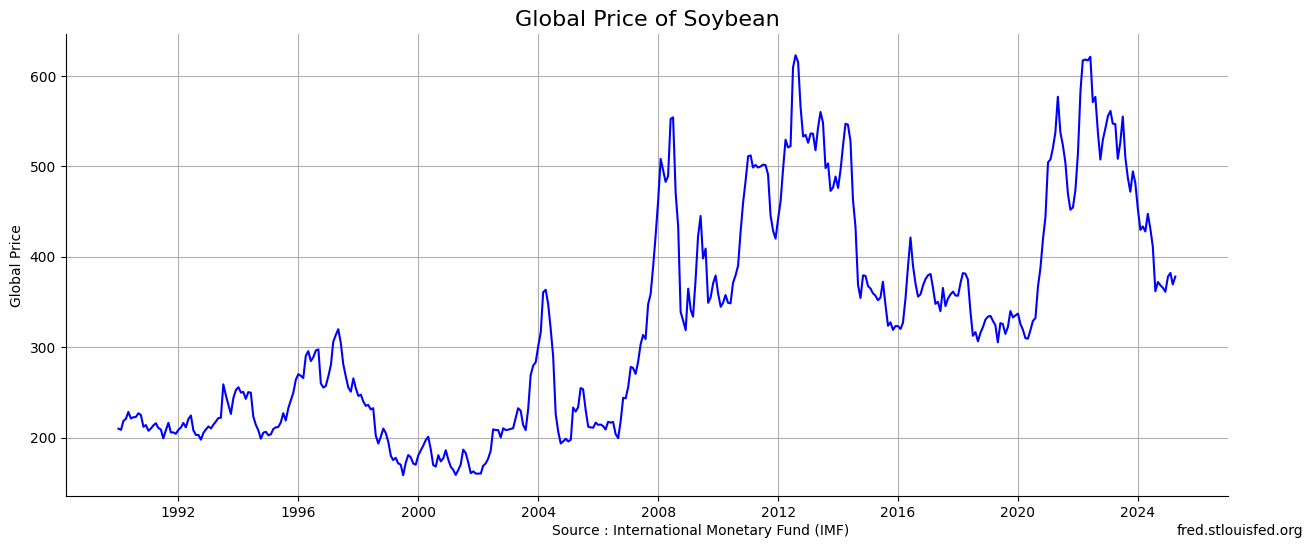

In [6]:
fig,ax = plt.subplots(figsize = myfigsize)
ax.plot(soybean_df.index, soybean_df['Soybean'],color='blue')
ax.set_ylabel('Global Price')
ax.set_title('Global Price of Soybean',{'fontsize': 16})
sns.despine(ax=ax)
plt.annotate('Source : International Monetary Fund (IMF)', (0,0), (350,-20), fontsize=10, 
             xycoords='axes fraction', textcoords='offset points', va='top')
plt.annotate('fred.stlouisfed.org', (0,0), (800,-20), fontsize=10, 
             xycoords='axes fraction', textcoords='offset points', va='top')
plt.grid()

Since stationarity is one of the primary assumptions of ARIMA models, we will use the Augmented Dickey-Fuller test to check our series stationarity.

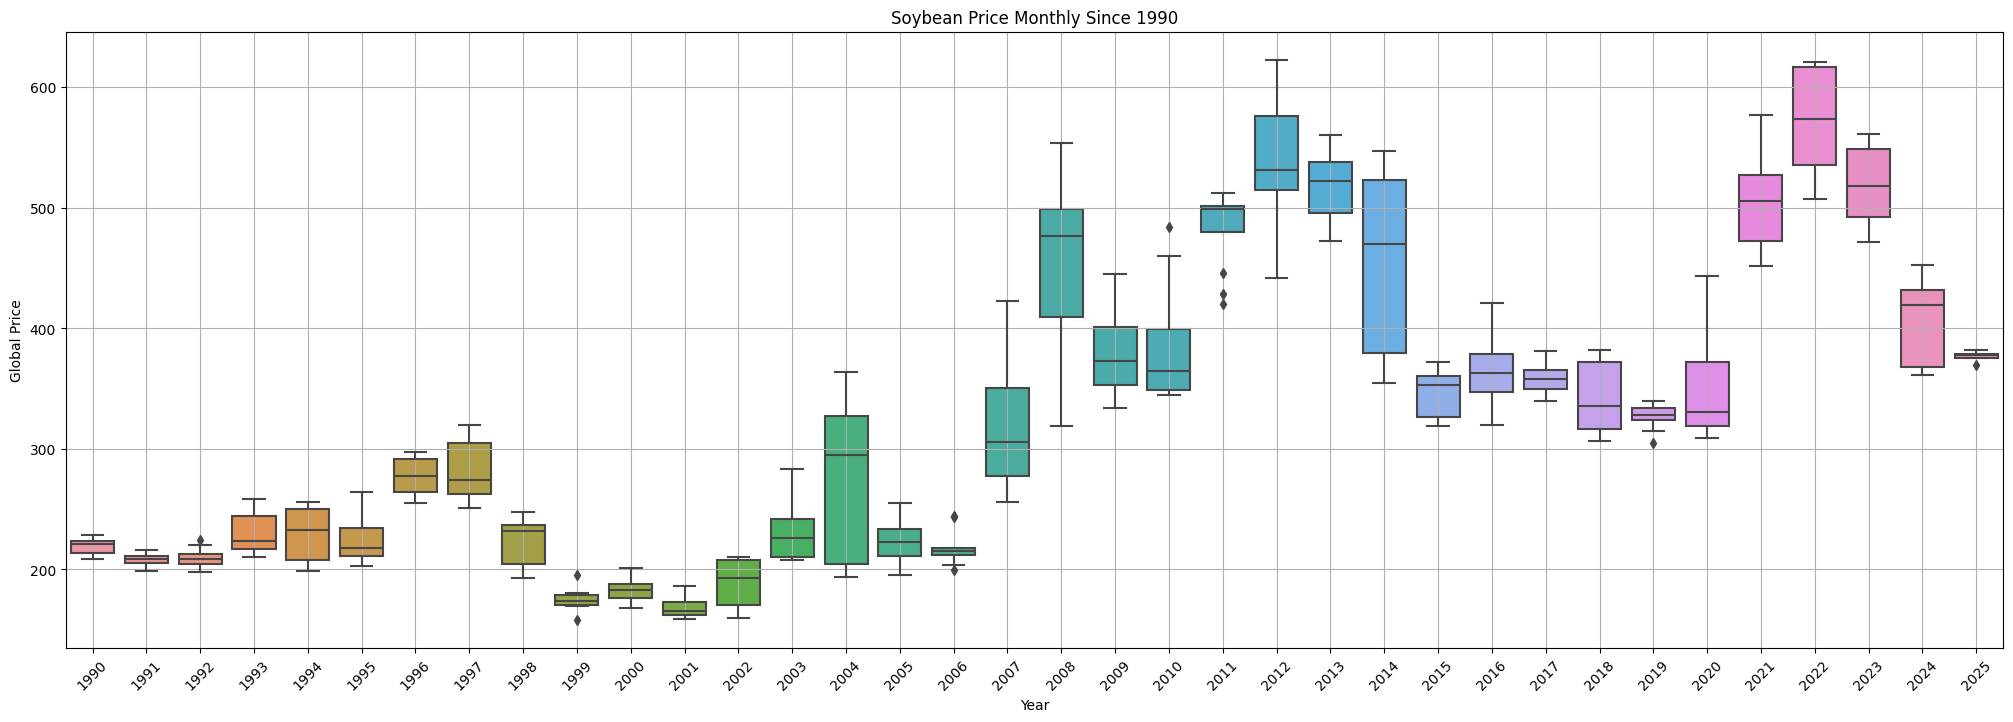

In [31]:
soybean_df.index = pd.to_datetime(soybean_df.index)


soybean_df['Year'] = soybean_df.index.year


fig, ax = plt.subplots(figsize=(25, 8))
sns.boxplot(x=soybean_df['Year'], y=soybean_df.iloc[:, 0], ax=ax)  # Assuming the first column is price

plt.title('Soybean Price Monthly Since 1990')
plt.ylabel('Global Price')
plt.xticks(rotation=45)
plt.grid()

plt.show()

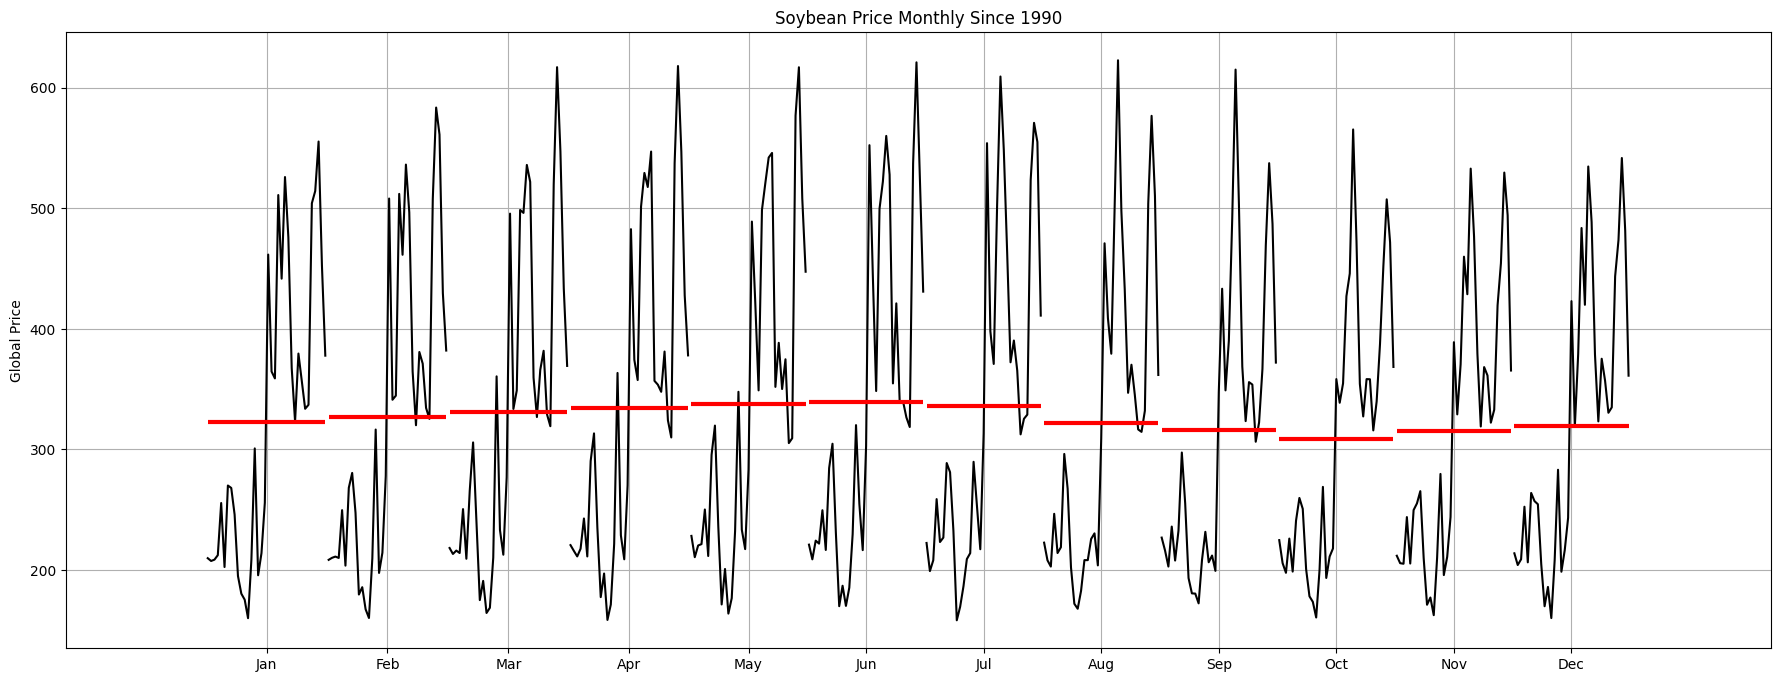

In [8]:
from statsmodels.graphics.tsaplots import month_plot

fig,ax =plt.subplots(figsize=(22,8))
month_plot(soybean_df.iloc[:, 0],ylabel ='Global Price', ax=ax)

plt.title('Soybean Price Monthly Since 1990')
plt.ylabel('Global Price')

plt.grid()

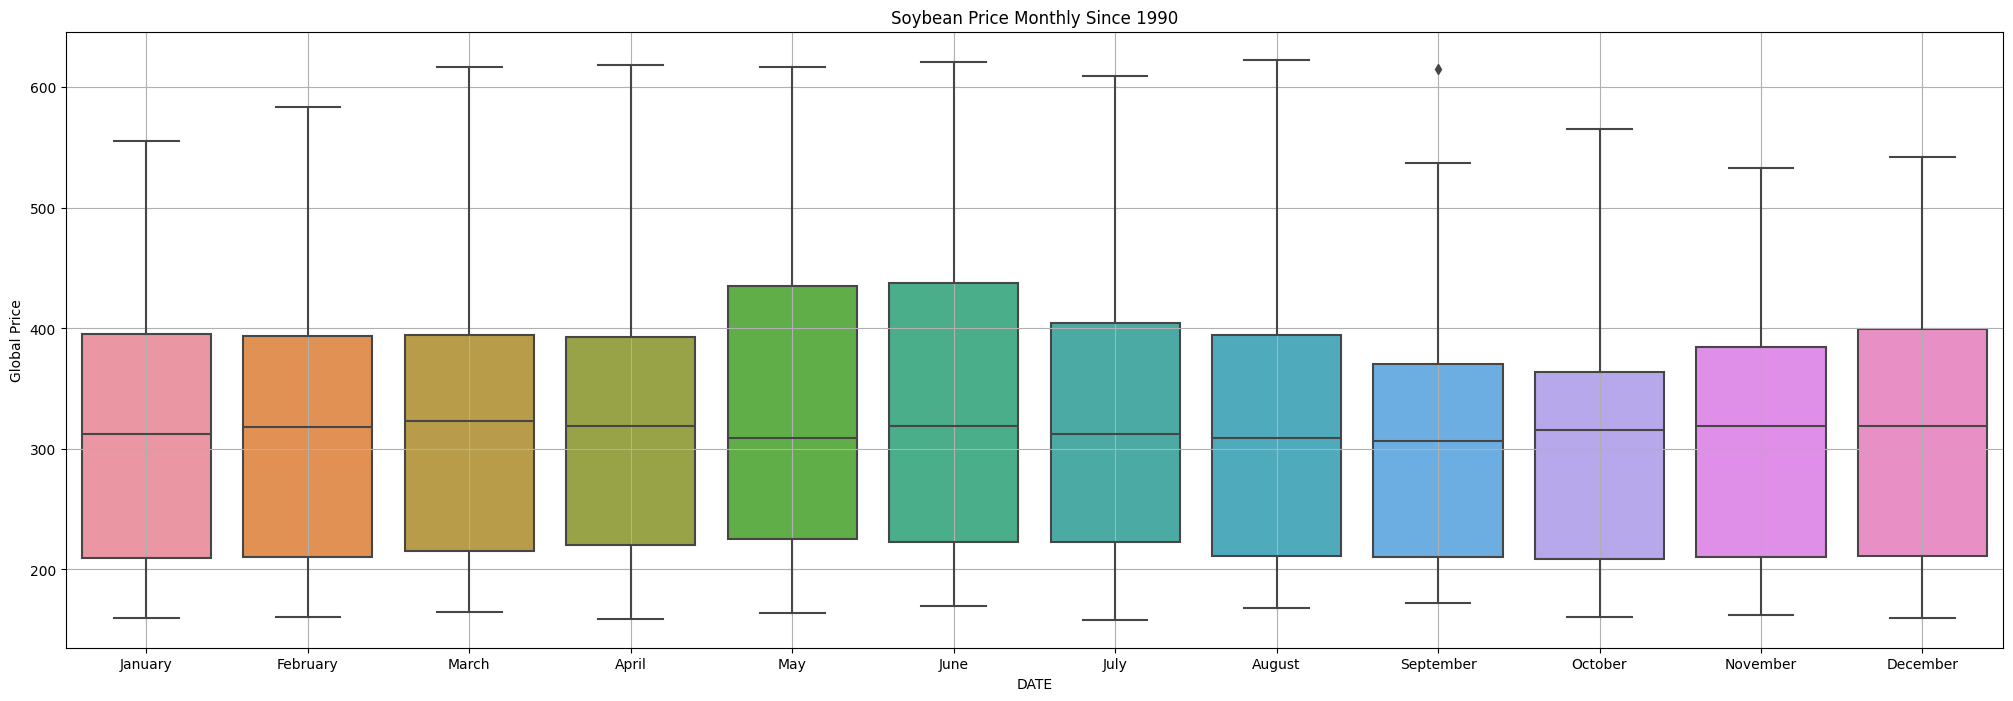

In [9]:
fig, ax = plt.subplots(figsize=(25, 8))
sns.boxplot(x=soybean_df.index.month_name(), y=soybean_df.iloc[:, 0], ax=ax)  # Assuming the first column is price

plt.title('Soybean Price Monthly Since 1990')
plt.ylabel('Global Price')

plt.grid()

plt.show()

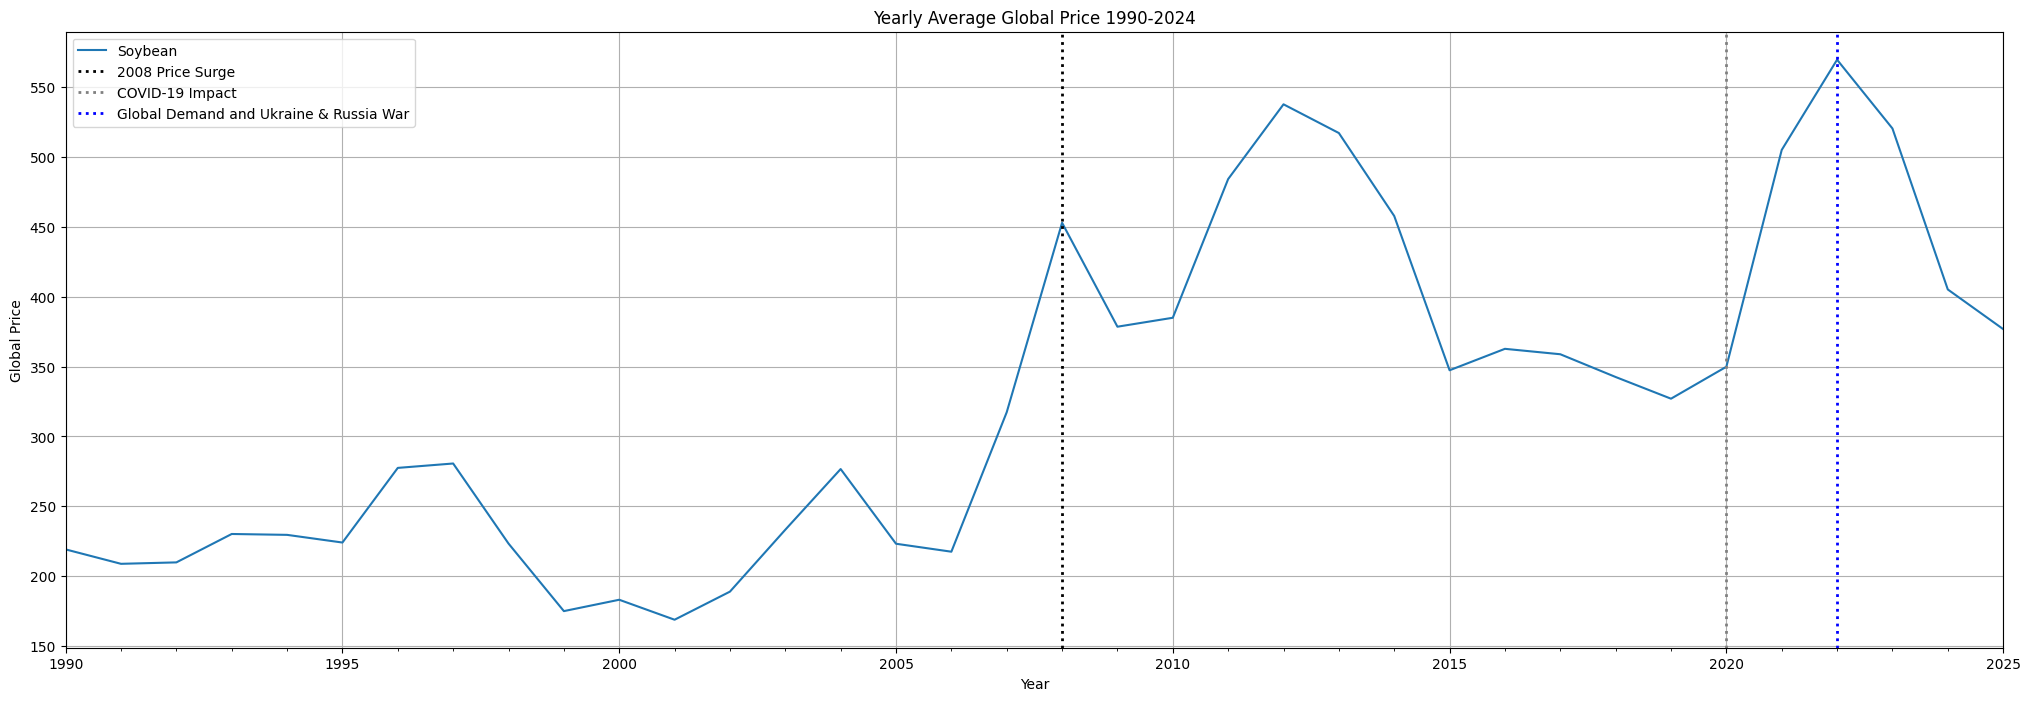

In [10]:
fig, ax = plt.subplots(figsize=(25, 8))
soybean_yr_sum =soybean_df.iloc[:, 0].resample('A').mean()
soybean_yr_sum.plot()
plt.title('Yearly Average Global Price 1990-2024')
plt.ylabel('Global Price')
plt.xlabel('Year')
plt.axvline(x='2008', color='black', linestyle=':', linewidth=2, label='2008 Price Surge')
plt.axvline(x='2020', color='gray', linestyle=':', linewidth=2, label='COVID-19 Impact')
plt.axvline(x='2022', color='blue', linestyle=':', linewidth=2, label='Global Demand and Ukraine & Russia War')
plt.legend()
plt.grid()
plt.show()

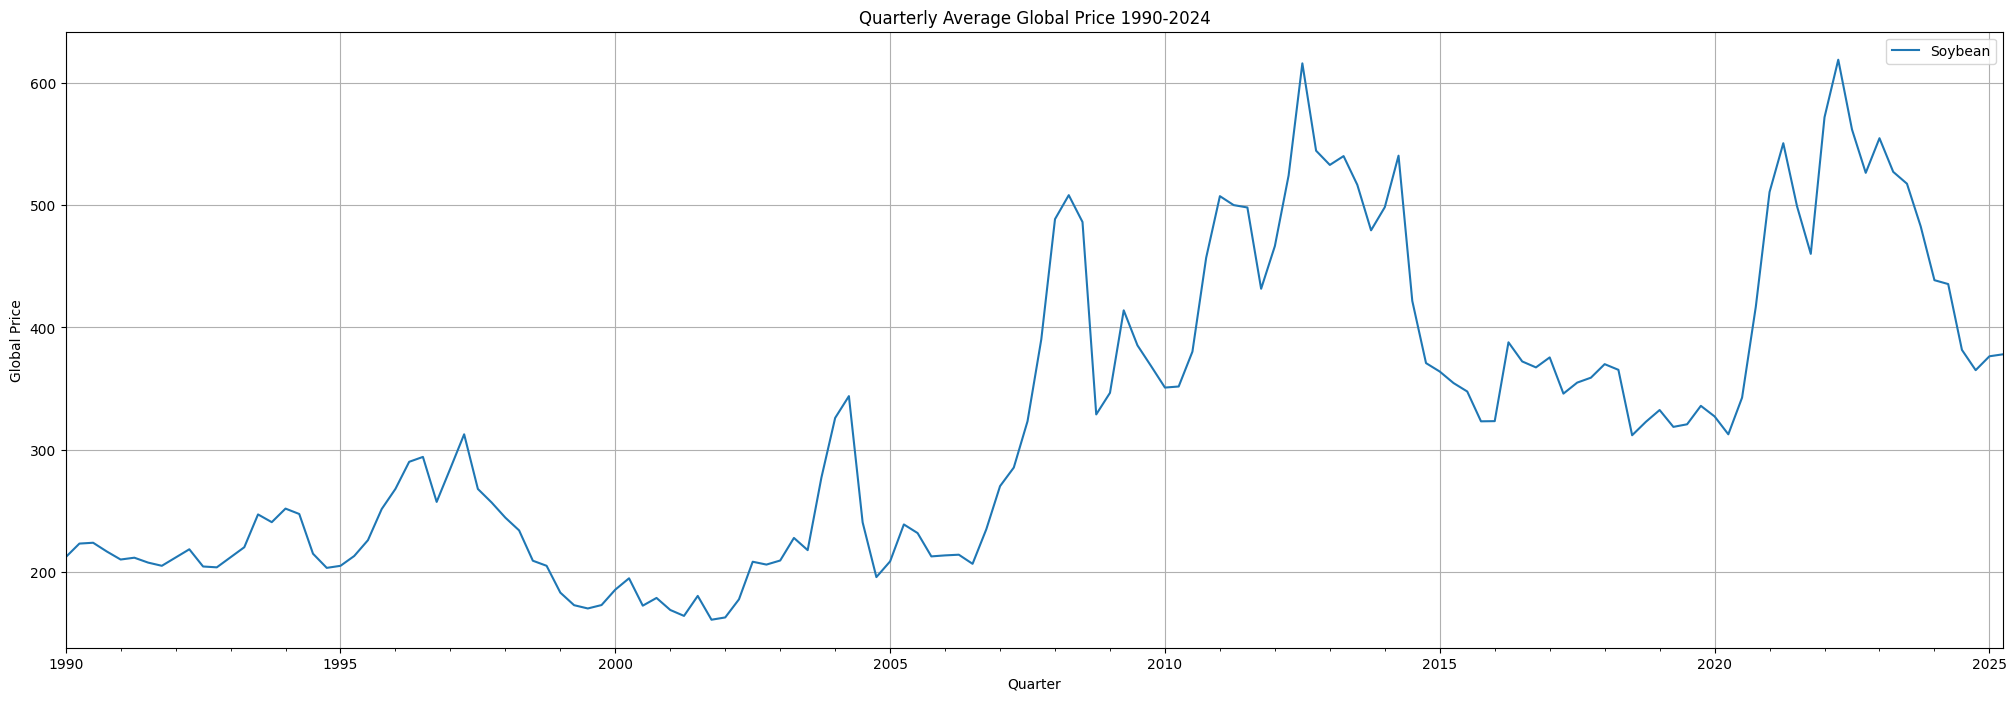

In [11]:
fig, ax = plt.subplots(figsize=(25, 8))
soybean_yr_sum =soybean_df.iloc[:, 0].resample('Q').mean()
soybean_yr_sum.plot()
plt.title('Quarterly Average Global Price 1990-2024')
plt.ylabel('Global Price')
plt.xlabel('Quarter')

plt.legend()
plt.grid()
plt.show()

In [12]:

soybean_df2 = soybean_df.groupby(soybean_df.index.year)['Soybean'].agg(['mean', 'std'])


soybean_df2 = soybean_df2.rename(columns={'mean': 'Mean', 'std': 'Std'})


soybean_df2['Cov_pct'] = ((soybean_df2['Std'] / soybean_df2['Mean']) * 100).round(2)

soybean_df2.head()



,Mean,Std,Cov_pct
DATE,,,
1990,219.100452,6.668614,3.04
1991,208.778652,4.937392,2.36
1992,209.802602,7.614169,3.63
1993,230.138060,16.826355,7.31
1994,229.510293,22.050551,9.61


In [13]:
soybean_df2.index = pd.to_datetime(soybean_df2.index, format='%Y')
soybean_df2.head()

,Mean,Std,Cov_pct
DATE,,,
1990-01-01,219.100452,6.668614,3.04
1991-01-01,208.778652,4.937392,2.36
1992-01-01,209.802602,7.614169,3.63
1993-01-01,230.138060,16.826355,7.31
1994-01-01,229.510293,22.050551,9.61


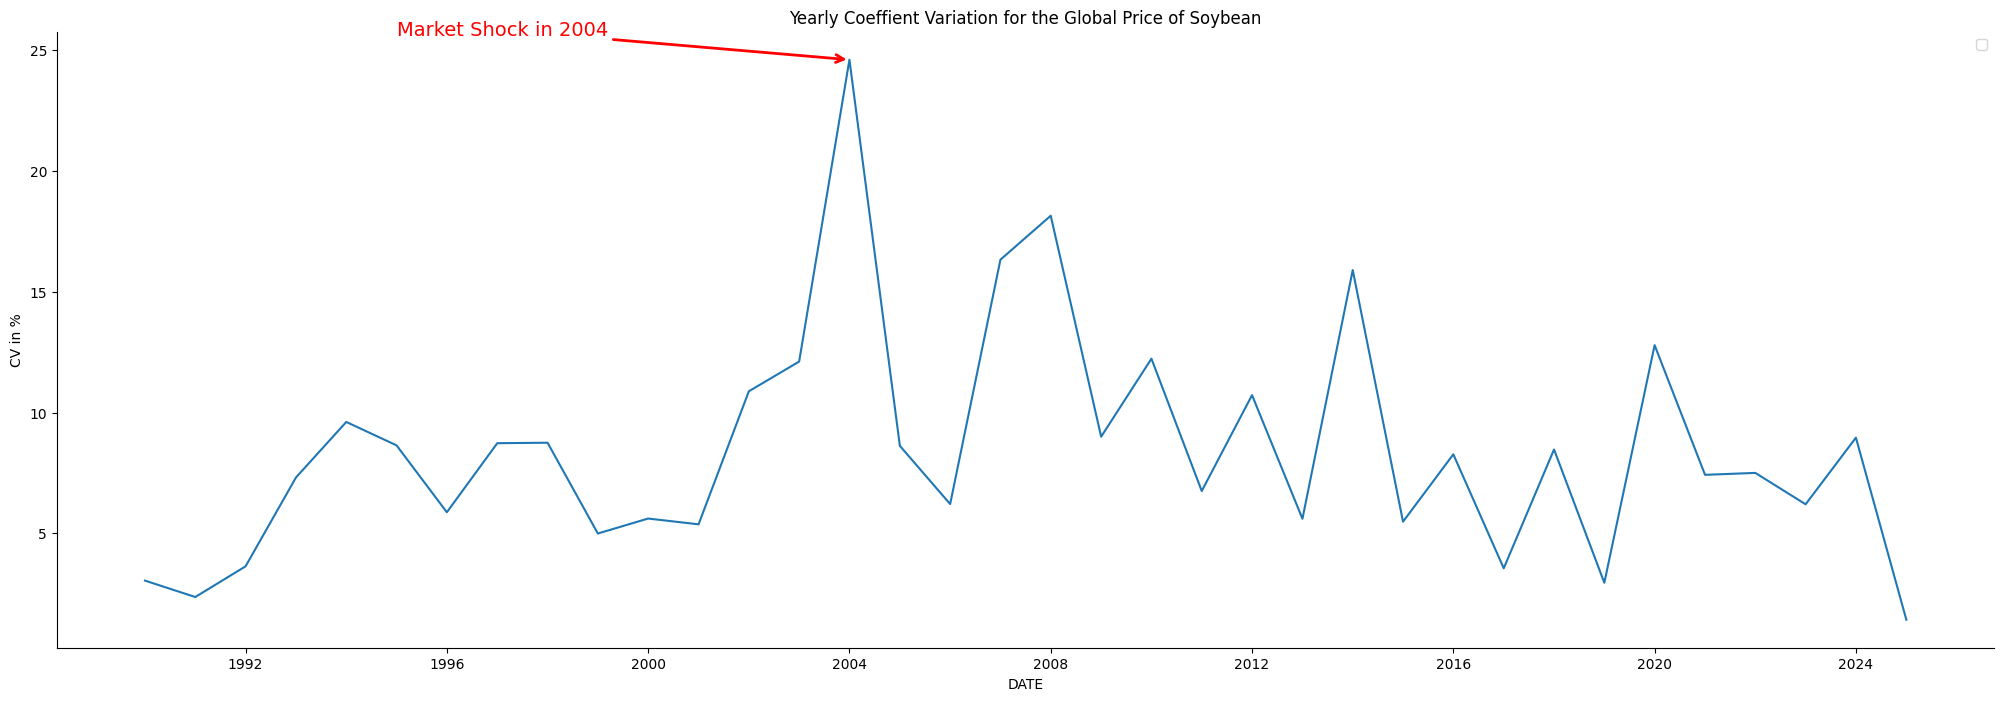

In [14]:

fig,ax = plt.subplots(figsize = (25,8))
sns.lineplot(data = soybean_df2, y='Cov_pct',x= soybean_df2.index)
plt.title('Yearly Coeffient Variation for the Global Price of Soybean')
#plt.axvline(x=pd.Timestamp('2004-01-01'), color='red', linestyle=':', linewidth=2, label= 'Highest Volatility')
plt.ylabel('CV in %')
plt.annotate(
    "Market Shock in 2004",  # Annotation text
    xy=(pd.Timestamp('2004-01-01'), soybean_df2.loc['2004', 'Cov_pct']),  # Point to annotate
    xytext=(pd.Timestamp('1995-01-01'), soybean_df2['Cov_pct'].max() + 1),  # Text location
    arrowprops=dict(arrowstyle="->", color="red", lw=2),  # Arrow style
    fontsize=14,
    color="red"
)
plt.legend()
sns.despine()
plt.show()

# Augmented Dickey Fuller Test for Stationarity

In [15]:

def ad_fuller_test(ts):
    df_test = adfuller(ts, autolag='AIC')
    
    df_output = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
   
    for key, value in df_test[4].items():
        df_output[f'Critical Value ({key})'] = value
    
   
    print(df_output)
    return df_output 



In [16]:

def plot_rolling_stats(ts):
    rolling_mean = ts.rolling(window=12, center=False).mean()
    rolling_std = ts.rolling(window=12, center=False).std()

    # Plot rolling statistics
    plt.plot(ts, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


Test Statistic                  -2.151696
p-value                          0.224241
#Lags Used                       1.000000
Number of Observations Used    422.000000
Critical Value (1%)             -3.445941
Critical Value (5%)             -2.868413
Critical Value (10%)            -2.570431
dtype: float64


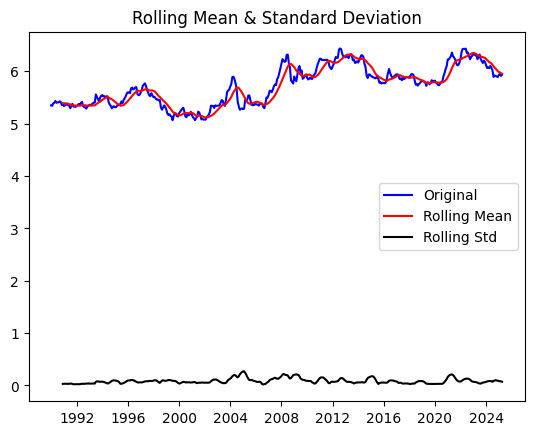

In [17]:
log_series = np.log(soybean_df['Soybean'])
ad_fuller_test(log_series)
plot_rolling_stats(log_series)


T-statistics = -2.157965 is the computed ADF test statistic, which measures how strongly the series follows a unit root process (non-stationary behavior).
If the test statistic is more negative than the critical values, it indicates the series is likely stationary.
Interpretation: Since -2.157965 is not more negative than any of the critical values, the test fails to reject the null hypothesis.
Moreover from the plot, the rolling mean shows non-stationarity of the mean accross the years.

Test Statistic                -1.500514e+01
p-value                        1.075522e-27
#Lags Used                     0.000000e+00
Number of Observations Used    4.220000e+02
Critical Value (1%)           -3.445941e+00
Critical Value (5%)           -2.868413e+00
Critical Value (10%)          -2.570431e+00
dtype: float64


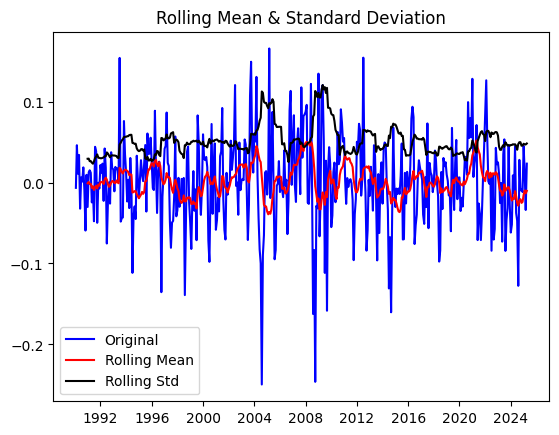

In [18]:
log_series_shift = log_series.diff().dropna()


ad_fuller_test(log_series_shift)

plot_rolling_stats(log_series_shift)

One way to achieve stationarity in a time series with a time-varying mean is to apply "differencing". That’s precisely what we did: we computed the first-order differenced log series.

Since the p-value is significantly below the 1% and 5% significance thresholds, we can reject the null hypothesis and conclude that the log-transformed and differenced series is stationary.

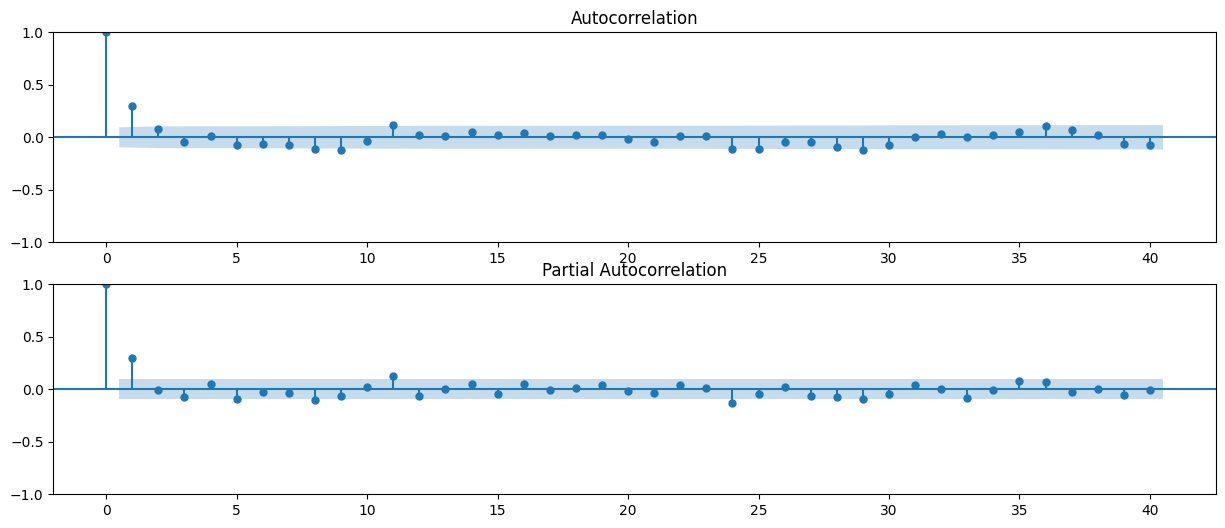

In [19]:
fig = plt.figure(figsize =myfigsize)
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_series_shift.squeeze(), lags =40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_series_shift, lags =40, ax=ax2)

The output plots show a sudden drop at lag  for both both ACF and PACF,thus pointing toward possible values of q and p to be 1 each, respectively.

ACF indicates that your time series might have an MA(1) process (i.e., a Moving Average process of order 1), as the autocorrelation at lag 1 is significant, and it quickly decays to zero.
PACF suggests an AR(1) process (i.e., an AutoRegressive process of order 1), as the partial autocorrelation at lag 1 is significant, and it drops afterward.
Thus, based on these plots, it seems that your series might be best modeled with an ARMA(1, 1) model, where both AR(1) and MA(1) components are present.

In [20]:
soybean_df['log_series'] = np.log(soybean_df['Soybean'])
soybean_df

,Soybean,Year,log_series
DATE,,,
1990-01-01,209.827483,1990,5.346286
1990-02-01,208.449456,1990,5.339697
1990-03-01,218.279378,1990,5.385776
1990-04-01,220.667957,1990,5.396659
1990-05-01,228.316003,1990,5.430731
...,...,...,...
2024-12-01,361.236501,2024,5.889533
2025-01-01,377.853040,2025,5.934505
2025-02-01,382.083957,2025,5.945640


In [21]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

# Define the function for ARIMA grid search with cross-validation
def arima_gridsearch_cv(series, cv_splits=5):
    # Define the p, d, and q ranges
    p = d = q = range(0, 3)  

    # Generate all combinations of p, d, and q
    pdq_combinations = list(itertools.product(p, d, q))

    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    
    results = []
    
    for train_index, test_index in tscv.split(series):
        train, test = series.iloc[train_index], series.iloc[test_index]

        for param in pdq_combinations:
            try:
                # Fit the ARIMA model on the training data
                model = ARIMA(train, order=param)
                fitted_model = model.fit()

                # Store AIC and parameters
                results.append({
                    'order': param,
                    'AIC': fitted_model.aic
                })

            except Exception as e:
                continue
    
    # Convert results to a DataFrame and sort by AIC
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='AIC')

    return results_df

# Apply the grid search to the log-transformed series
results_dict = arima_gridsearch_cv(soybean_df['log_series'], cv_splits=5)

# Print the best order with the lowest AIC
print("Best ARIMA order:", results_dict.iloc[0]['order'])
print("Lowest AIC:", results_dict.iloc[0]['AIC'])


Best ARIMA order: (1, 1, 2)
Lowest AIC: -1069.579033219173


In [22]:
model = ARIMA(soybean_df['log_series'],order = (1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             log_series   No. Observations:                  424
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 653.034
Date:                Thu, 05 Jun 2025   AIC                          -1298.068
Time:                        11:14:04   BIC                          -1281.878
Sample:                    01-01-1990   HQIC                         -1291.671
                         - 04-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5941      0.214     -2.771      0.006      -1.014      -0.174
ma.L1          0.9080      0.203      4.477      0.000       0.510       1.306
ma.L2          0.2876      0.057      5.085      0.0

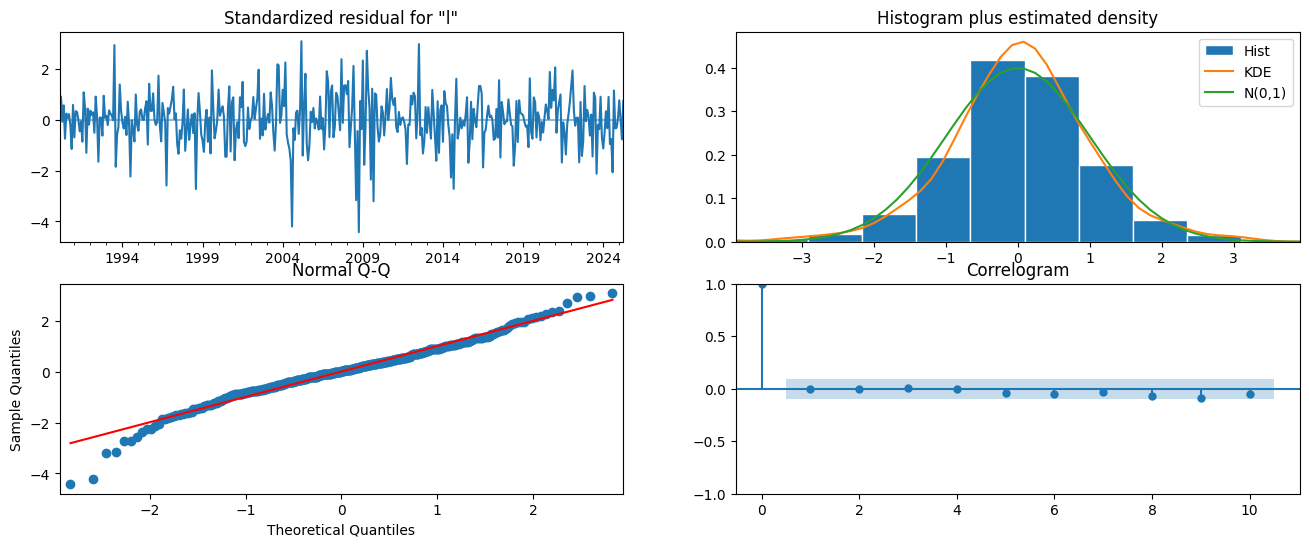

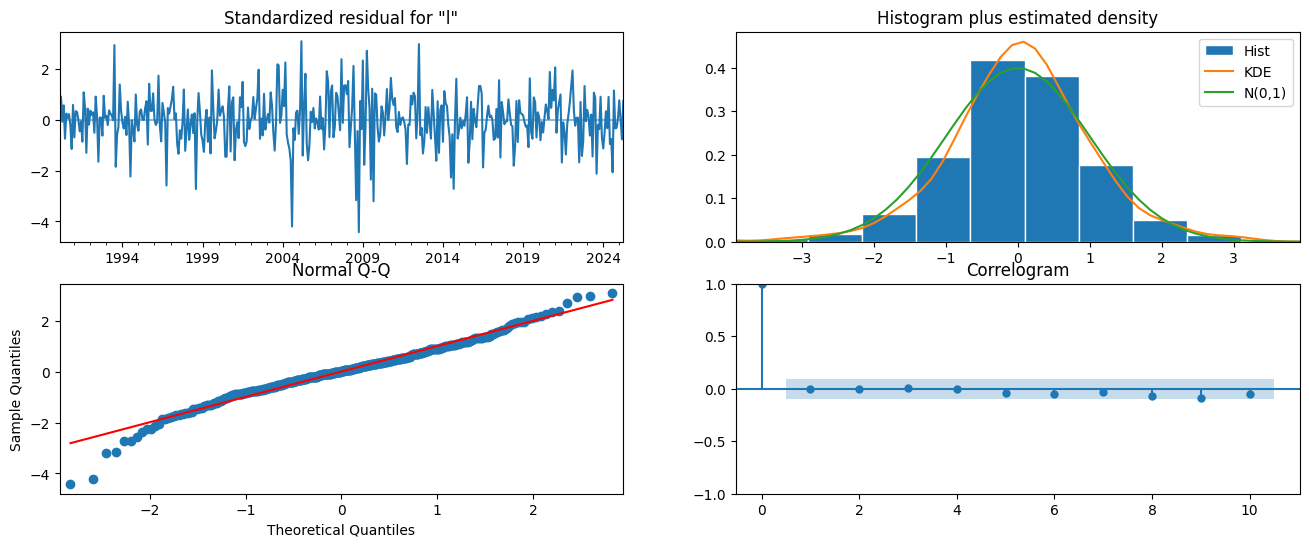

In [33]:
model_fit.plot_diagnostics(figsize=(16, 6))


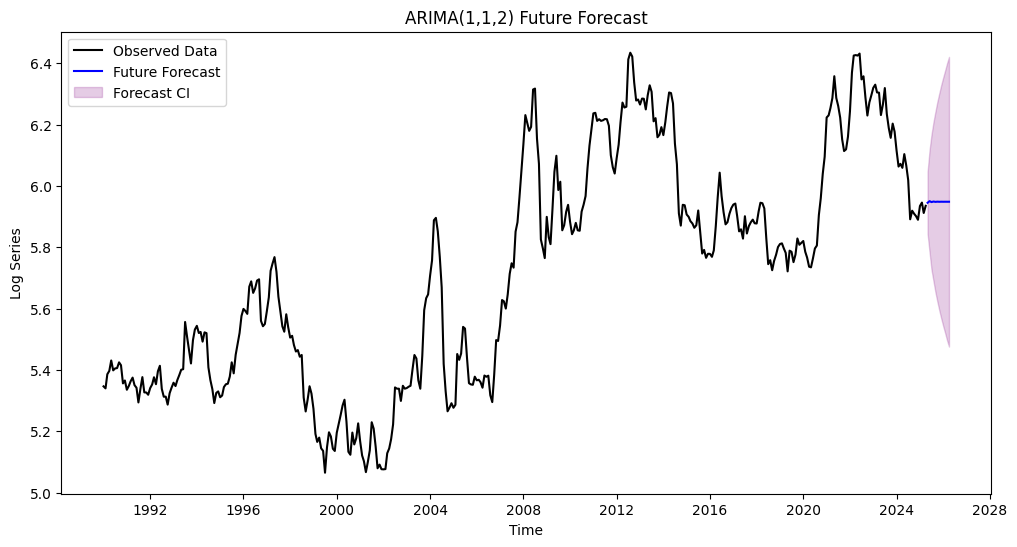

In [37]:
# Refit ARIMA(1,1,2) on the full dataset
full_series = soybean_df['log_series']
model = ARIMA(full_series, order=(1,1,2))
model_fit = model.fit()

# Forecast the next 12 months 
future_steps = 12
forecast_results_future = model_fit.get_forecast(steps=future_steps)

forecast_mean_future = forecast_results_future.predicted_mean
forecast_ci_future = forecast_results_future.conf_int()

# Generate future datetime index
last_date = soybean_df.index[-1]
#for monthly frequency
future_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=future_steps, freq='MS')

# Plotting full series + forecast
plt.figure(figsize=(12, 6))
plt.plot(soybean_df.index, full_series, label="Observed Data", color="black")
plt.plot(future_index, forecast_mean_future, label="Future Forecast", color="blue")
plt.fill_between(future_index, 
                 forecast_ci_future.iloc[:, 0], 
                 forecast_ci_future.iloc[:, 1], 
                 color= "purple", alpha=0.2, label="Forecast CI")

plt.legend()
plt.title("ARIMA(1,1,2) Soybean Price Future Forecast")
plt.xlabel("Time")
plt.ylabel("Log Series")
plt.show()
